# survival analysis example

Let's use `stan` to code up a simple Bayesian Cox Proportional Hazards Model.

## A couple general things about survival analysis

The high-level problem we have is modeling "how long til an event happens?". Lots of obvious applications in medicine and insurance.

* One important practical concept is "censoring"- a member of your dataset may have exited the study before an event happened. For example, in a medical study, somebody was still alive at the end of it, or someone got hit by a car before the disease killed them. So you don't know how long it was until the event happened, but you *do know* the time was greater than some number. Survival analysis models can generally handle a mix of uncensored and censored data.

* If you're familiar with generalized linear models, then this might just sound like a GLM with an exponential link function. Under such a model, *conditioned on the covariates* the event would have a constant probability per time of occurring. Survival models frequently use the *Weibull distribution*, which looks sort of like an exponential with an additional "shape parameter" $k$.

  * if $k = 1$, the Weibull reduces to an exponential
  * if $k > 1$, then all other things being equal the event probability per time tends to increase over time (think probability of dying from cancer or an aging industrial component failing)
  * if $k < 1$, then all other things being equal the event probability per time tends to decrease (such as an industrial component failing due to defects)

## A couple general thoughts about this notebook/approach

* I'm using a gamma prior over the Weibull shape parameter. Note that `stan` and `numpy` parameterize this distribution differently.
* The closest examples I found in `stan`used the `target +=` syntax. `target` isn't exactly a variable but in some cases acts like one- you basically use it as an accumulator for the log likelihood.
* There are some high-level software packages (`stan`-based and otherwise) for survival analysis; it might be worth investigating some of them if we want to start using these more seriously.

For a good explanation of `stan`'s `target` syntax, check page 373-374 of Lambert's book. He also uses it in a code example on page 482.

## Data

I wanted a small-ish multivariate survival dataset with both censored and uncensored data. I've been using the VA lung cancer dataset posted here: http://www.stat.rice.edu/~sneeley/STAT553/Datasets/survivaldata.txt 

>VA lung cancer data 
>
>Patients with advanced, inoperable lung cancer were treated with chemotherapy. 
>
>N = 137 
>
> Veteran's Administration Lung Cancer Trial 
>
> Taken from Kalbfleisch and Prentice, pages 223-224  
>

### Variables
* Treatment 1=standard, 2=test 
* Cell type 1=squamous, 2=small cell, 3=adeno, 4=large 
* Survival in days 
* Status 1=dead, 0=censored 
* Karnofsky score (measure of general performance, 100=best) 
* Months from Diagnosis 
* Age in years 
* Prior therapy 0=no, 10=yes 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystan

%matplotlib inline
from IPython.core.pylabtools import figsize

# Data loading and EDA

Let's take a look at some of the variables

In [2]:
df = pd.read_csv("lungcancer.csv")
len(df)

137

In [3]:
df.head()

,treatment,celltype,survival_days,status,karnofsky,months_from_diagnosis,age_yrs,prior_therapy
0,1,1,72,1,60,7,69,0
1,1,1,411,1,70,5,64,10
2,1,1,228,1,60,3,38,0
3,1,1,126,1,60,9,63,10
4,1,1,118,1,70,11,65,10


In [4]:
celltype = pd.get_dummies(df.celltype)
celltype.columns = ["squamous", "small cell", "adeno", "large"]
celltype.head()

,squamous,small cell,adeno,large
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [5]:
df.treatment.value_counts()

1    69
2    68
Name: treatment, dtype: int64

In [6]:
df.celltype.value_counts()

2    48
1    35
4    27
3    27
Name: celltype, dtype: int64

In [7]:
# censoring
df.status.value_counts()

1    128
0      9
Name: status, dtype: int64

In [8]:
df.prior_therapy.value_counts()

0     97
10    40
Name: prior_therapy, dtype: int64

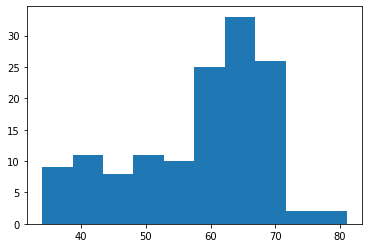

In [9]:
plt.hist(df.age_yrs);

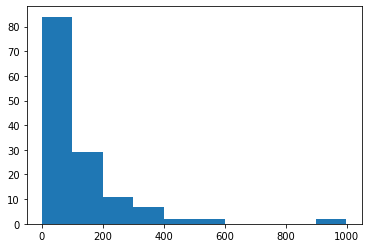

In [10]:
plt.hist(df.survival_days);

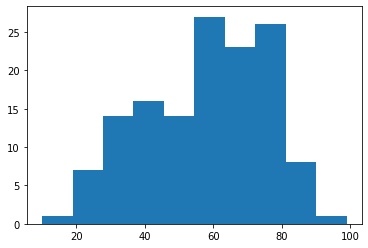

In [11]:
plt.hist(df.karnofsky);

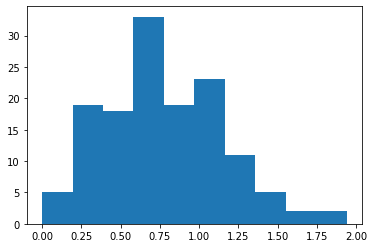

In [12]:
plt.hist(np.log10(df.months_from_diagnosis));

In [13]:
df.pivot_table(values="survival_days", index=["treatment", "status"], aggfunc=np.mean)

survival_days
treatment status               
1         0           105.40000
          1           115.90625
2         0           126.00000
          1           128.34375

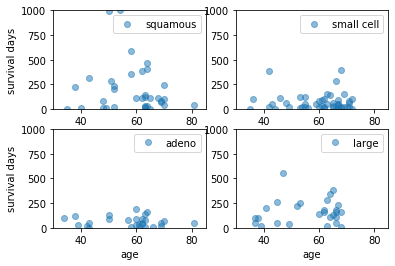

In [38]:
celltypes = ["squamous", "small cell", "adeno", "large"]
for c in [1,2,3,4]:
    plt.subplot(2,2,c)
    plt.plot(df.age_yrs[df.celltype==c], df.survival_days[df.celltype==c], "o", alpha=0.5, label=celltypes[c-1])
    plt.xlim(30,85)
    plt.ylim(0,1000)
    plt.legend(loc="upper right")
    if c in [3,4]:
        plt.xlabel("age")
    if c in [1,3]:
        plt.ylabel("survival days");
    
    

## Transforming data for modeling

Let's get everything onto a common scale (note- we could also just choose different priors for each if we wanted)

In [15]:
# xcols = treatment, small cell, adeno, large, karnofsky, months from diagnosis, age, prior therapy
X = np.concatenate([
    df.treatment.values.reshape(-1,1)-1, # treatment
    celltype.values[:,1:], # 3 binary columns for cell type
    df.karnofsky.values.reshape(-1,1)/100, # normalized Karnofsky score
    np.log10(df.months_from_diagnosis.values.reshape(-1,1)), # months from diagnosis on a log scale
    df.age_yrs.values.reshape(-1,1)/80, # rescaled age
    df.prior_therapy.values.reshape(-1,1)/10 # 
], 1)
X.shape

(137, 8)

In [16]:
# target variable
y = df.survival_days.values
y.shape

(137,)

In [17]:
# censored/uncensored indicator
uncensored = df.status == 1

## the model

This should look (mostly) like a standard linear regression with a bit of pizzazz. Notably:

* separate uncensored and censored inputs (though the coefficients are shared)
* PMFs and CDFs of the Weibull distribution added to the `target`
* a Gamma prior over the Weibull shape distribution

In [18]:
model_code = """
data {
  // number of covariates
  int K;
  
  // uncensored inputs
  int N_u;
  vector[N_u] y_u;
  matrix[N_u, K] X_u;
  
  // censored inputs
  int N_c;
  vector[N_c] y_c;
  matrix[N_c, K] X_c;
  
  // priors
  vector[K] beta_scale;
  real intercept_scale;
  
  // gamma prior over Weibull shape param
  real gamma_alpha;
  real gamma_beta;
}
parameters {
  // regression coefficients for each covariate
  vector[K] beta;
  // regression intercept
  real intercept;
  // Weibull distribution shape parameter
  real<lower=0> shape;
}
model{
  // shape parameter prior
  shape ~ gamma(gamma_alpha, gamma_beta);
  
  // priors for the regression coefficients
  beta ~ normal(0, beta_scale);
  intercept ~ normal(0, intercept_scale);
  
  // likelihood: log-PDF for uncensored data and log-CDF for censored
  target += weibull_lpdf(y_u| shape, exp(intercept + X_u*beta));
  target += weibull_lccdf(y_c| shape, exp(intercept + X_c*beta));
}
"""

In [19]:
%%time
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_89056e972e9980a924f9809d4ae004ca NOW.


CPU times: user 1.46 s, sys: 82.4 ms, total: 1.55 s
Wall time: 53.7 s


In [20]:
%%time
K = X.shape[1]
gamma_alpha = 10
gamma_beta = 10
data = {"y_u":y[uncensored],
        "X_u":X[uncensored],
        "N_u":X[uncensored].shape[0],
        "y_c":y[~uncensored],
        "X_c":X[~uncensored],
        "N_c":X[~uncensored].shape[0],
       "K":K,
       "beta_scale":5*np.ones(K),
       "intercept_scale":10,
       "gamma_alpha":gamma_alpha,
       "gamma_beta":gamma_beta}

fit = model.sampling(data=data, iter=2000, chains=4)

CPU times: user 55.7 ms, sys: 36.9 ms, total: 92.6 ms
Wall time: 4.5 s


## Investigating the results

In [21]:
traces = fit.extract()

### Weibull shape parameter

For this case, my naive expectation would be a shape parameter greater than 1.

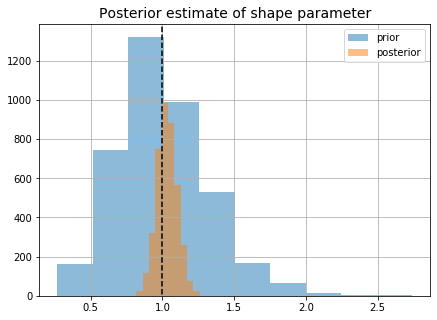

In [22]:
figsize(7,5)
plt.hist(np.random.gamma(gamma_alpha, 1/gamma_beta, size=len(traces["shape"])), alpha=0.5, label="prior")
plt.hist(traces["shape"], alpha=0.5, label="posterior")
plt.grid(True)
ax = plt.axis()
plt.vlines(1, -1e6, 1e6, linestyle="dashed")
plt.axis(ax)
plt.legend(loc="upper right")
plt.title("Posterior estimate of shape parameter", fontsize=14);

### Regression coefficients

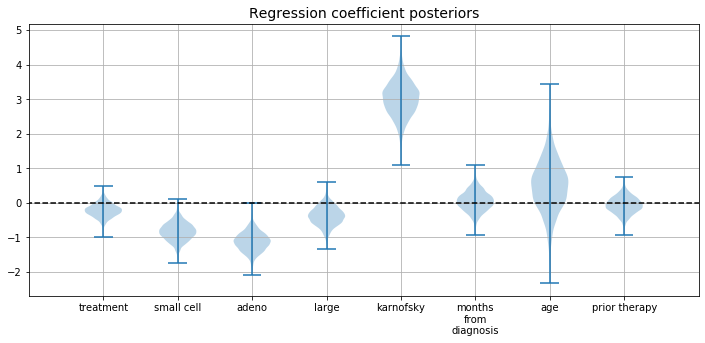

In [23]:
figsize(12,5)
xcols = ["treatment", "small cell", "adeno", "large", "karnofsky", "months\nfrom\ndiagnosis", 
         "age", "prior therapy"]

plt.violinplot(traces["beta"])
plt.xticks(np.arange(1,9), xcols)
plt.grid(True)
plt.hlines(0, -1, 9, linestyles="dashed")
plt.xlim(0, 9)
plt.title("Regression coefficient posteriors", fontsize=14);

Looks like the Karnofsky score is really strongly predictive- is it highly-correlated with our target variable?

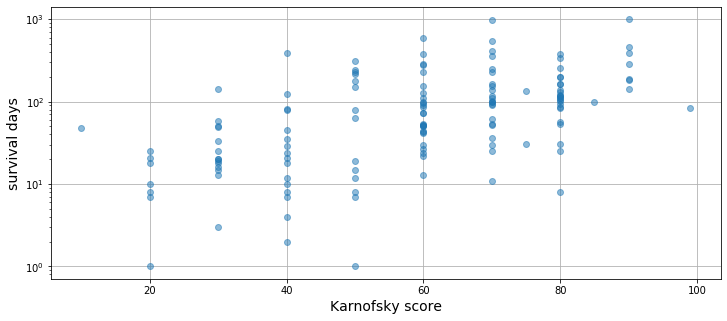

In [24]:
figsize(12,5)
plt.plot(df.karnofsky, df.survival_days, "o", alpha=0.5)
plt.yscale("log")
plt.xlabel("Karnofsky score", fontsize=14)
plt.ylabel("survival days", fontsize=14)
plt.grid(True);

### Posterior predictive distribution

Comparing real with simulated data drawn from the PPD:

In [25]:
logits = (traces["beta"].dot(X.T) + np.expand_dims(traces["intercept"],1))
logits.shape

(4000, 137)

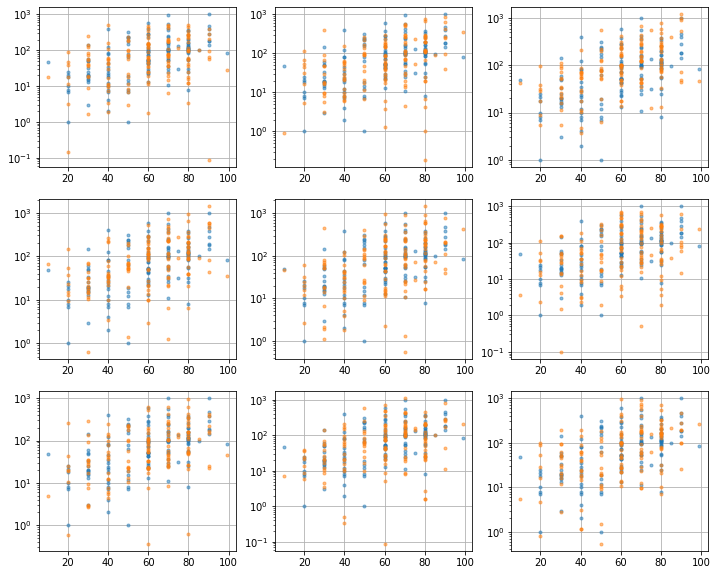

In [26]:
figsize(12,10)
j = 1
for i in np.random.choice(np.arange(logits.shape[0]), size=9):
    plt.subplot(3,3,j)
    shape = traces["shape"][i]
    weibull = np.random.weibull(shape, size=logits.shape[1])
    plt.plot(df.karnofsky, df.survival_days, ".", alpha=0.5)
    plt.plot(df.karnofsky, weibull*np.exp(logits[i,:]), ".", alpha=0.5)
    plt.yscale("log")
    plt.grid(True);
    j += 1

We could also look at summary stats on real and synthetic data broken out by one of the variables:

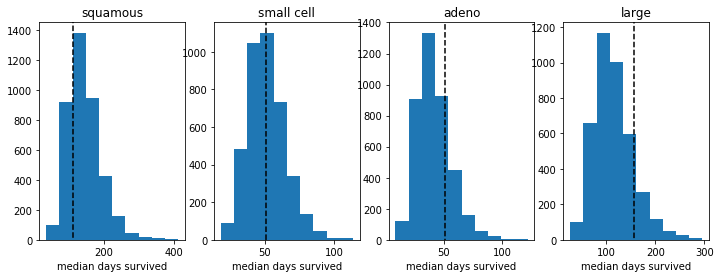

In [27]:
figsize(12,4)
typenames = ["squamous", "small cell", "adeno", "large"]

for i in range(4):
    plt.subplot(1,4,i+1)
    subset = df.celltype == i+1
    med_days = np.median(df.survival_days[subset].values)
    
    N = subset.sum()
    posterior_medians = [
        np.median(np.random.weibull(traces["shape"][j], size=N)*np.exp(logits[j,subset]))
        for j in range(logits.shape[0])
    ]
    plt.hist(posterior_medians)
    ax = plt.axis()
    plt.vlines(med_days, -1e6,1e6, linestyles="dashed")
    plt.axis(ax)
    xlim = plt.xlim()
    plt.xlim(min(xlim[0], med_days-1), max(xlim[1], med_days+1))
    plt.title(typenames[i])
    plt.xlabel("median days survived");

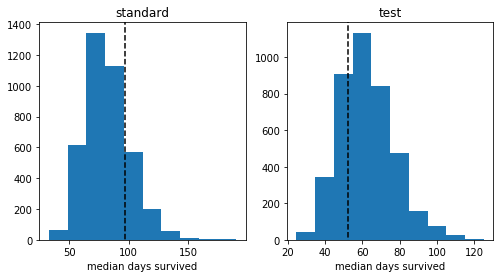

In [28]:
figsize(17,4)
treatmentnames = ["standard", "test"]
for i in range(2):
    plt.subplot(1,4,i+1)
    subset = df.treatment == i+1
    med_days = np.median(df.survival_days[subset].values)
    
    N = subset.sum()
    posterior_medians = [
        np.median(np.random.weibull(traces["shape"][j], size=N)*np.exp(logits[j,subset]))
        for j in range(logits.shape[0])
    ]
    plt.hist(posterior_medians)
    ax = plt.axis()
    plt.vlines(med_days, -1e6,1e6, linestyles="dashed")
    plt.axis(ax)
    xlim = plt.xlim()
    plt.xlim(min(xlim[0], med_days-1), max(xlim[1], med_days+1))
    plt.title(treatmentnames[i])
    plt.xlabel("median days survived");